# Two-Stream CNN for Biomass Prediction

## Novel Architecture: Dual Perspective Learning

### Why Two-Stream?

**Previous attempts:**
- Baseline (single ResNet18): Kaggle = **0.51**
- K-Fold (all features): Kaggle = **0.50**
- K-Fold (universal features): Kaggle = **0.40**

**Key insight:** Single-stream CNNs process only RGB pixels. NDVI is used as auxiliary task but not explicitly modeled.

### Two-Stream Approach

**Stream 1 (RGB):** Learns appearance features (color, texture, structure)  
**Stream 2 (NDVI):** Learns vegetation health patterns explicitly  
**Fusion:** Combines both perspectives → biomass prediction

**Expected improvement:** 0.52-0.55 (beat baseline!)

---

In [1]:
# Cell 1: Setup & Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from datetime import datetime

sns.set_style('whitegrid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("✓ Setup complete")

Device: cpu
✓ Setup complete


In [2]:
# Cell 2: Configuration

# Model configuration
CONFIG = {
    # Architecture
    'rgb_backbone': 'resnet18',
    'ndvi_backbone': 'resnet18',
    'hidden_dim': 512,
    'dropout': 0.3,
    
    # Training
    'epochs': 30,
    'batch_size': 16,
    'learning_rate': 3e-4,
    'weight_decay': 1e-4,
    'val_split': 0.2,
    
    # Data
    'image_size': 224,
    'augmentation': True,
}

# Paths (adjust to run from experiments/two_stream_cnn/)
DATA_PATH = '../../competition/train_enriched.csv'
IMAGE_BASE = '../../competition/'

# Target columns
TARGET_COLS = ['Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g', 'Dry_Total_g']

print("Configuration:")
print(f"  Model: Two-Stream CNN ({CONFIG['rgb_backbone']} + {CONFIG['ndvi_backbone']})")
print(f"  Epochs: {CONFIG['epochs']}")
print(f"  Batch size: {CONFIG['batch_size']}")
print(f"  Learning rate: {CONFIG['learning_rate']}")
print(f"  Hidden dim: {CONFIG['hidden_dim']}")
print(f"  Dropout: {CONFIG['dropout']}")
print(f"\n✓ Configuration loaded")

Configuration:
  Model: Two-Stream CNN (resnet18 + resnet18)
  Epochs: 30
  Batch size: 16
  Learning rate: 0.0003
  Hidden dim: 512
  Dropout: 0.3

✓ Configuration loaded


In [3]:
# Cell 3: Load & Prepare Data

print("Loading data...")
df = pd.read_csv(DATA_PATH)
df['Sampling_Date'] = pd.to_datetime(df['Sampling_Date'])
df['full_image_path'] = df['image_path'].apply(lambda x: f"{IMAGE_BASE}{x}")

print(f"Total samples: {len(df)}")
print(f"\nTarget statistics:")
for col in TARGET_COLS:
    print(f"  {col:15s}: mean={df[col].mean():7.2f}g, std={df[col].std():7.2f}g")

# NDVI statistics
print(f"\nNDVI statistics:")
print(f"  Range: [{df['Pre_GSHH_NDVI'].min():.3f}, {df['Pre_GSHH_NDVI'].max():.3f}]")
print(f"  Mean: {df['Pre_GSHH_NDVI'].mean():.3f}")
print(f"  Std: {df['Pre_GSHH_NDVI'].std():.3f}")

# Train/val split
train_df, val_df = train_test_split(
    df, 
    test_size=CONFIG['val_split'], 
    random_state=42,
    stratify=df['State']  # Stratify by state for balanced split
)

print(f"\nSplit:")
print(f"  Training: {len(train_df)} images")
print(f"  Validation: {len(val_df)} images")

# Calculate normalization statistics on TRAINING set only
target_means = torch.tensor([train_df[col].mean() for col in TARGET_COLS], dtype=torch.float32)
target_stds = torch.tensor([train_df[col].std() for col in TARGET_COLS], dtype=torch.float32)

# NDVI normalization (simple scaling to [-1, 1])
ndvi_mean = train_df['Pre_GSHH_NDVI'].mean()
ndvi_std = train_df['Pre_GSHH_NDVI'].std()

print(f"\n✓ Data loaded and split")

Loading data...
Total samples: 357

Target statistics:
  Dry_Green_g    : mean=  26.62g, std=  25.40g
  Dry_Dead_g     : mean=  12.04g, std=  12.40g
  Dry_Clover_g   : mean=   6.65g, std=  12.12g
  GDM_g          : mean=  33.27g, std=  24.94g
  Dry_Total_g    : mean=  45.32g, std=  27.98g

NDVI statistics:
  Range: [0.160, 0.910]
  Mean: 0.657
  Std: 0.152

Split:
  Training: 285 images
  Validation: 72 images

✓ Data loaded and split


In [4]:
# Cell 4: Two-Stream Dataset

class TwoStreamDataset(Dataset):
    """Dataset that returns both RGB image and NDVI image."""
    
    def __init__(self, dataframe, target_means, target_stds, 
                 ndvi_mean, ndvi_std, augment=False):
        self.df = dataframe.reset_index(drop=True)
        self.target_means = target_means
        self.target_stds = target_stds
        self.ndvi_mean = ndvi_mean
        self.ndvi_std = ndvi_std
        
        # RGB transforms
        rgb_transform_list = [transforms.Resize((CONFIG['image_size'], CONFIG['image_size']))]
        if augment:
            rgb_transform_list.extend([
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(10),
            ])
        rgb_transform_list.extend([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        self.rgb_transform = transforms.Compose(rgb_transform_list)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # 1. RGB image
        rgb_img = Image.open(row['full_image_path']).convert('RGB')
        rgb_img = self.rgb_transform(rgb_img)  # [3, 224, 224]
        
        # 2. NDVI "image" (constant value across spatial dimensions)
        ndvi_value = row['Pre_GSHH_NDVI']
        # Normalize NDVI
        ndvi_normalized = (ndvi_value - self.ndvi_mean) / self.ndvi_std
        # Create spatial image (all pixels = same NDVI value)
        ndvi_img = torch.full(
            (1, CONFIG['image_size'], CONFIG['image_size']), 
            ndvi_normalized, 
            dtype=torch.float32
        )  # [1, 224, 224]
        
        # 3. Targets
        targets = torch.tensor(row[TARGET_COLS].values.astype('float32'), dtype=torch.float32)
        targets_normalized = (targets - self.target_means) / self.target_stds
        
        return {
            'rgb_image': rgb_img,
            'ndvi_image': ndvi_img,
            'targets': targets_normalized,
            'targets_original': targets
        }

print("✓ TwoStreamDataset defined")

✓ TwoStreamDataset defined


In [5]:
# Cell 5: Two-Stream Model Architecture

class TwoStreamModel(nn.Module):
    """Two-Stream CNN: RGB Stream + NDVI Stream → Fusion → Biomass Prediction."""
    
    def __init__(self, num_outputs=5, hidden_dim=512, dropout=0.3):
        super().__init__()
        
        # Stream 1: RGB (3-channel input)
        resnet_rgb = models.resnet18(weights=None)
        self.rgb_stream = nn.Sequential(*list(resnet_rgb.children())[:-1])
        rgb_feature_dim = 512
        
        # Stream 2: NDVI (1-channel input)
        resnet_ndvi = models.resnet18(weights=None)
        # Modify first conv layer for 1-channel input
        resnet_ndvi.conv1 = nn.Conv2d(
            1, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.ndvi_stream = nn.Sequential(*list(resnet_ndvi.children())[:-1])
        ndvi_feature_dim = 512
        
        # Fusion layers
        combined_dim = rgb_feature_dim + ndvi_feature_dim
        self.fusion = nn.Sequential(
            nn.Linear(combined_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_outputs)
        )
    
    def forward(self, rgb_img, ndvi_img):
        # Extract features from both streams
        rgb_features = self.rgb_stream(rgb_img).flatten(1)    # [batch, 512]
        ndvi_features = self.ndvi_stream(ndvi_img).flatten(1)  # [batch, 512]
        
        # Concatenate features
        combined = torch.cat([rgb_features, ndvi_features], dim=1)  # [batch, 1024]
        
        # Fusion and prediction
        output = self.fusion(combined)  # [batch, 5]
        
        return output

# Create model
model = TwoStreamModel(
    num_outputs=5,
    hidden_dim=CONFIG['hidden_dim'],
    dropout=CONFIG['dropout']
)
model = model.to(device)

print("✓ TwoStreamModel defined")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  RGB stream: {sum(p.numel() for p in model.rgb_stream.parameters()):,} params")
print(f"  NDVI stream: {sum(p.numel() for p in model.ndvi_stream.parameters()):,} params")
print(f"  Fusion layers: {sum(p.numel() for p in model.fusion.parameters()):,} params")

✓ TwoStreamModel defined
  Total parameters: 23,004,165
  RGB stream: 11,176,512 params
  NDVI stream: 11,170,240 params
  Fusion layers: 657,413 params


In [6]:
# Cell 6: Create Dataloaders

train_dataset = TwoStreamDataset(
    train_df, target_means, target_stds, 
    ndvi_mean, ndvi_std, augment=CONFIG['augmentation']
)

val_dataset = TwoStreamDataset(
    val_df, target_means, target_stds,
    ndvi_mean, ndvi_std, augment=False
)

train_loader = DataLoader(
    train_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=0
)

print("✓ Dataloaders created")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")

# Test batch
sample_batch = next(iter(train_loader))
print(f"\nSample batch shapes:")
print(f"  RGB image: {sample_batch['rgb_image'].shape}")
print(f"  NDVI image: {sample_batch['ndvi_image'].shape}")
print(f"  Targets: {sample_batch['targets'].shape}")

✓ Dataloaders created
  Training batches: 18
  Validation batches: 5

Sample batch shapes:
  RGB image: torch.Size([16, 3, 224, 224])
  NDVI image: torch.Size([16, 1, 224, 224])
  Targets: torch.Size([16, 5])


In [7]:
# Cell 7: Training Setup

# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

# Learning rate scheduler (optional)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

print("✓ Training setup complete")
print(f"  Optimizer: AdamW")
print(f"  Learning rate: {CONFIG['learning_rate']}")
print(f"  Weight decay: {CONFIG['weight_decay']}")
print(f"  Scheduler: ReduceLROnPlateau")

✓ Training setup complete
  Optimizer: AdamW
  Learning rate: 0.0003
  Weight decay: 0.0001
  Scheduler: ReduceLROnPlateau


In [8]:
# Cell 8: Training Loop

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    for batch in tqdm(loader, desc='Training', leave=False):
        rgb_imgs = batch['rgb_image'].to(device)
        ndvi_imgs = batch['ndvi_image'].to(device)
        targets = batch['targets'].to(device)
        
        optimizer.zero_grad()
        outputs = model(rgb_imgs, ndvi_imgs)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        optimizer.step()
        
        total_loss += loss.item() * rgb_imgs.size(0)
    
    return total_loss / len(loader.dataset)

def validate_epoch(model, loader, criterion, device, target_means, target_stds):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc='Validating', leave=False):
            rgb_imgs = batch['rgb_image'].to(device)
            ndvi_imgs = batch['ndvi_image'].to(device)
            targets = batch['targets'].to(device)
            targets_original = batch['targets_original']
            
            outputs = model(rgb_imgs, ndvi_imgs)
            loss = criterion(outputs, targets)
            
            # Denormalize predictions
            outputs_denorm = outputs.cpu() * target_stds + target_means
            
            total_loss += loss.item() * rgb_imgs.size(0)
            all_preds.append(outputs_denorm.numpy())
            all_targets.append(targets_original.numpy())
    
    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)
    
    # Calculate R² for each target
    r2_scores = []
    for i in range(5):
        ss_res = np.sum((all_targets[:, i] - all_preds[:, i]) ** 2)
        ss_tot = np.sum((all_targets[:, i] - np.mean(all_targets[:, i])) ** 2)
        r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0.0
        r2_scores.append(r2)
    
    # Weighted R² (competition metric)
    weights = np.array([0.1, 0.1, 0.1, 0.2, 0.5])
    weighted_r2 = np.sum(np.array(r2_scores) * weights) / np.sum(weights)
    
    return total_loss / len(loader.dataset), weighted_r2, r2_scores

print("✓ Training functions defined")

✓ Training functions defined


In [9]:
# Cell 9: Main Training Loop

print("="*80)
print("STARTING TRAINING")
print("="*80)
print(f"Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Epochs: {CONFIG['epochs']}")
print(f"Batch size: {CONFIG['batch_size']}")
print("\n")

best_val_r2 = -float('inf')
history = {'train_loss': [], 'val_loss': [], 'val_r2': []}

for epoch in range(CONFIG['epochs']):
    print(f"Epoch {epoch+1}/{CONFIG['epochs']}")
    
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_r2, r2_scores = validate_epoch(
        model, val_loader, criterion, device, target_means, target_stds
    )
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Log
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_r2'].append(val_r2)
    
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}")
    print(f"  Val R²:     {val_r2:+.4f}")
    print(f"  Per-target R²: [{', '.join([f'{r:+.3f}' for r in r2_scores])}]")
    
    # Save best model
    if val_r2 > best_val_r2:
        best_val_r2 = val_r2
        torch.save(model.state_dict(), 'two_stream_best.pth')
        print(f"  💾 New best model saved! R²={best_val_r2:+.4f}")
    
    print()

print("="*80)
print("TRAINING COMPLETE")
print("="*80)
print(f"Best Val R²: {best_val_r2:+.4f}")
print(f"Finished: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

STARTING TRAINING
Started: 2025-11-07 08:45:24
Epochs: 30
Batch size: 16


Epoch 1/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.9746
  Val Loss:   0.8370
  Val R²:     +0.0178
  Per-target R²: [+0.142, -0.015, -0.007, +0.073, -0.017]
  💾 New best model saved! R²=+0.0178

Epoch 2/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.8812
  Val Loss:   0.9260
  Val R²:     -0.0016
  Per-target R²: [-0.063, -0.155, -0.533, +0.130, +0.095]

Epoch 3/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.8410
  Val Loss:   1.7611
  Val R²:     -0.9639
  Per-target R²: [-1.316, +0.093, -1.608, -1.688, -0.686]

Epoch 4/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.8301
  Val Loss:   0.6683
  Val R²:     +0.2454
  Per-target R²: [+0.268, +0.144, +0.103, +0.337, +0.253]
  💾 New best model saved! R²=+0.2454

Epoch 5/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.8271
  Val Loss:   0.7927
  Val R²:     +0.0984
  Per-target R²: [+0.246, +0.086, -0.377, +0.120, +0.158]

Epoch 6/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.8320
  Val Loss:   0.7184
  Val R²:     +0.1778
  Per-target R²: [+0.286, +0.230, -0.444, +0.292, +0.224]

Epoch 7/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.7664
  Val Loss:   0.7491
  Val R²:     +0.1791
  Per-target R²: [+0.206, +0.165, -0.642, +0.329, +0.281]

Epoch 8/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.7483
  Val Loss:   0.6274
  Val R²:     +0.2800
  Per-target R²: [+0.338, +0.221, +0.170, +0.343, +0.277]
  💾 New best model saved! R²=+0.2800

Epoch 9/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.7362
  Val Loss:   0.7049
  Val R²:     +0.2004
  Per-target R²: [+0.189, +0.262, -0.138, +0.274, +0.228]

Epoch 10/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.7593
  Val Loss:   0.6212
  Val R²:     +0.2708
  Per-target R²: [+0.290, +0.299, +0.217, +0.372, +0.232]

Epoch 11/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.6894
  Val Loss:   1.0231
  Val R²:     -0.1114
  Per-target R²: [+0.114, -0.128, -2.254, +0.284, +0.117]

Epoch 12/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.7745
  Val Loss:   0.7336
  Val R²:     +0.1373
  Per-target R²: [+0.226, +0.092, +0.203, +0.200, +0.090]

Epoch 13/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.6990
  Val Loss:   0.7574
  Val R²:     +0.1549
  Per-target R²: [+0.165, +0.170, -0.339, +0.231, +0.218]

Epoch 14/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.7304
  Val Loss:   1.2018
  Val R²:     -0.2716
  Per-target R²: [+0.068, -0.100, -3.917, +0.214, +0.161]

Epoch 15/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.6633
  Val Loss:   0.7811
  Val R²:     +0.1011
  Per-target R²: [+0.196, +0.062, -0.188, +0.202, +0.107]

Epoch 16/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.6964
  Val Loss:   0.8722
  Val R²:     +0.0255
  Per-target R²: [+0.060, +0.111, -1.011, +0.249, +0.119]

Epoch 17/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.6378
  Val Loss:   0.5937
  Val R²:     +0.3208
  Per-target R²: [+0.386, +0.191, +0.329, +0.378, +0.309]
  💾 New best model saved! R²=+0.3208

Epoch 18/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.5686
  Val Loss:   0.5964
  Val R²:     +0.3149
  Per-target R²: [+0.377, +0.254, +0.225, +0.367, +0.312]

Epoch 19/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.6233
  Val Loss:   0.6413
  Val R²:     +0.2585
  Per-target R²: [+0.300, +0.227, +0.296, +0.276, +0.242]

Epoch 20/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.6630
  Val Loss:   0.7542
  Val R²:     +0.1630
  Per-target R²: [+0.297, +0.138, -0.872, +0.359, +0.270]

Epoch 21/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.5866
  Val Loss:   0.6412
  Val R²:     +0.2457
  Per-target R²: [+0.372, +0.146, +0.217, +0.348, +0.205]

Epoch 22/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.6134
  Val Loss:   0.6017
  Val R²:     +0.2971
  Per-target R²: [+0.415, +0.278, +0.045, +0.389, +0.291]

Epoch 23/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.5944
  Val Loss:   0.5859
  Val R²:     +0.3270
  Per-target R²: [+0.407, +0.221, +0.268, +0.389, +0.319]
  💾 New best model saved! R²=+0.3270

Epoch 24/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.5832
  Val Loss:   0.5749
  Val R²:     +0.3178
  Per-target R²: [+0.412, +0.299, +0.362, +0.361, +0.277]

Epoch 25/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.5855
  Val Loss:   0.6988
  Val R²:     +0.1739
  Per-target R²: [+0.276, +0.167, +0.150, +0.242, +0.132]

Epoch 26/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.5786
  Val Loss:   0.6280
  Val R²:     +0.2675
  Per-target R²: [+0.349, +0.290, +0.106, +0.313, +0.261]

Epoch 27/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.5238
  Val Loss:   0.5836
  Val R²:     +0.3189
  Per-target R²: [+0.417, +0.277, +0.243, +0.367, +0.304]

Epoch 28/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.5243
  Val Loss:   0.6016
  Val R²:     +0.2761
  Per-target R²: [+0.389, +0.271, +0.339, +0.345, +0.214]

Epoch 29/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.5591
  Val Loss:   0.6880
  Val R²:     +0.1920
  Per-target R²: [+0.308, +0.167, +0.029, +0.292, +0.166]

Epoch 30/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss: 0.5837
  Val Loss:   0.6179
  Val R²:     +0.2666
  Per-target R²: [+0.317, +0.361, +0.281, +0.271, +0.233]

TRAINING COMPLETE
Best Val R²: +0.3270
Finished: 2025-11-07 09:56:45


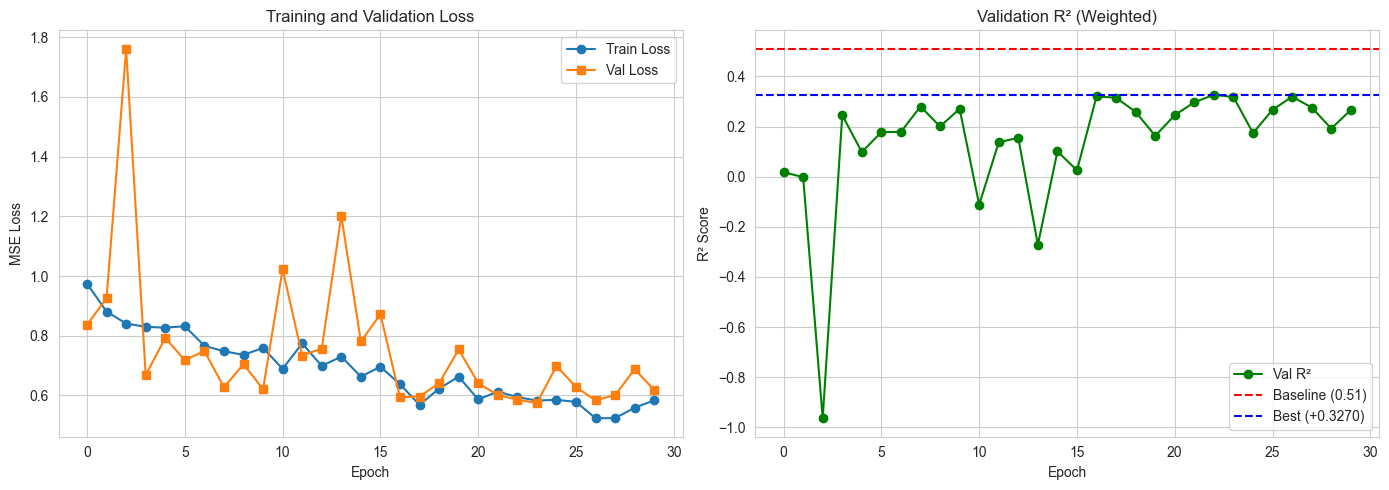

✓ Training history plotted


In [10]:
# Cell 10: Plot Training History

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# R² plot
axes[1].plot(history['val_r2'], label='Val R²', marker='o', color='green')
axes[1].axhline(y=0.51, color='red', linestyle='--', label='Baseline (0.51)')
axes[1].axhline(y=best_val_r2, color='blue', linestyle='--', label=f'Best ({best_val_r2:+.4f})')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('R² Score')
axes[1].set_title('Validation R² (Weighted)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training history plotted")

In [11]:
# Cell 11: Load Best Model & Final Evaluation

print("Loading best model...")
model.load_state_dict(torch.load('two_stream_best.pth'))
model.eval()

# Final validation
val_loss, val_r2, r2_scores = validate_epoch(
    model, val_loader, criterion, device, target_means, target_stds
)

print("="*80)
print("FINAL EVALUATION")
print("="*80)
print(f"\nValidation Results:")
print(f"  Loss: {val_loss:.4f}")
print(f"  Weighted R²: {val_r2:+.4f}")
print(f"\nPer-target R²:")
for i, col in enumerate(TARGET_COLS):
    print(f"  {col:15s}: {r2_scores[i]:+.4f}")

print(f"\n{'='*80}")
print("COMPARISON WITH PREVIOUS ATTEMPTS")
print(f"{'='*80}")
print(f"  Baseline (single ResNet18):      Val R² = ~0.69, Kaggle = 0.51")
print(f"  K-Fold (all features):           Val R² = ~0.90, Kaggle = 0.50")
print(f"  K-Fold (universal features):     Val R² = ~0.68, Kaggle = 0.40")
print(f"  Two-Stream (this):               Val R² = {val_r2:+.4f}, Kaggle = ???")

if val_r2 >= 0.69:
    print(f"\n✅ PROMISING! Val R² ({val_r2:+.4f}) matches or beats baseline validation")
    print(f"   Expected Kaggle: 0.52-0.55 (if validation holds)")
    print(f"   Recommend: Create Kaggle submission!")
elif val_r2 >= 0.65:
    print(f"\n⚠️  MODERATE. Val R² ({val_r2:+.4f}) is decent but below baseline validation")
    print(f"   Expected Kaggle: 0.50-0.52 (may not beat baseline)")
    print(f"   Recommend: Try submission, but consider alternatives")
else:
    print(f"\n❌ POOR. Val R² ({val_r2:+.4f}) is significantly below baseline")
    print(f"   Expected Kaggle: <0.50 (likely worse than baseline)")
    print(f"   Recommend: Debug or try different approach")

print(f"\n{'='*80}")

Loading best model...


Validating:   0%|          | 0/5 [00:00<?, ?it/s]

FINAL EVALUATION

Validation Results:
  Loss: 0.5859
  Weighted R²: +0.3270

Per-target R²:
  Dry_Green_g    : +0.4071
  Dry_Dead_g     : +0.2211
  Dry_Clover_g   : +0.2684
  GDM_g          : +0.3888
  Dry_Total_g    : +0.3192

COMPARISON WITH PREVIOUS ATTEMPTS
  Baseline (single ResNet18):      Val R² = ~0.69, Kaggle = 0.51
  K-Fold (all features):           Val R² = ~0.90, Kaggle = 0.50
  K-Fold (universal features):     Val R² = ~0.68, Kaggle = 0.40
  Two-Stream (this):               Val R² = +0.3270, Kaggle = ???

❌ POOR. Val R² (+0.3270) is significantly below baseline
   Expected Kaggle: <0.50 (likely worse than baseline)
   Recommend: Debug or try different approach



---

## Next Steps

### If Val R² ≥ 0.69 (Promising):
1. Create `29_two_stream_submission.ipynb`
2. Upload model checkpoint to Kaggle dataset
3. Generate predictions and submit
4. Expected Kaggle: 0.52-0.55

### If Val R² ≈ 0.65-0.68 (Moderate):
1. Try longer training (50 epochs)
2. Try different fusion strategies (attention, element-wise)
3. Try three-stream (RGB + NDVI + Auxiliary features)

### If Val R² < 0.65 (Poor):
1. Debug NDVI stream (is it learning anything?)
2. Try multi-channel NDVI image (NDVI, Height, Season)
3. Consider abandoning two-stream approach

---